## CSP 304: Machine Learning Lab (Spring 2023)
# Homework 4

Name: Samarth Bhatt <br>
College ID: 2020KUCP1068 <br>
Lab Batch: A3
<br>
<br>
<br>
<br>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# function to load data from a file
def load_data(file_path):
    data = np.loadtxt(file_path, delimiter=',')
    X = data[:, :-1]
    y = data[:, -1].astype(int)
    return X, y

# load training, validation, and test data from files
train_X, train_y = load_data('optdigits_train.txt')
val_X, val_y = load_data('optdigits_valid.txt')
test_X, test_y = load_data('optdigits_test.txt')

In [ ]:
# define a multi-layer perceptron class
class MLP:
    # constructor initializes weight matrices with random values
    def __init__(self, n_inputs, n_hidden, n_outputs):
        self.W = np.random.normal(size=(n_inputs + 1, n_hidden))
        self.V = np.random.normal(size=(n_hidden + 1, n_outputs))

    # ReLU activation function
    def relu(self, X):
        return np.maximum(X, 0)

    # softmax activation function
    def softmax(self, X):
        exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
        return exp_X / np.sum(exp_X, axis=1, keepdims=True)

    # forward pass through the network
    def forward(self, X):
        # add bias term to input layer
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        # calculate hidden layer activations using ReLU
        Z = self.relu(np.dot(X, self.W))
        # add bias term to hidden layer
        Z = np.hstack((Z, np.ones((Z.shape[0], 1))))
        # calculate output layer activations using softmax
        y = self.softmax(np.dot(Z, self.V))
        return Z, y

    # backward pass through the network
    def backward(self, X, Z, y, target, eta):
        # calculate derivative of loss with respect to output layer activations
        delta_v = (y - target) / X.shape[0]
        # calculate derivative of loss with respect to hidden layer activations
        delta_w = np.dot(delta_v, self.V[:-1, :].T) * (Z > 0)

        # calculate weight updates using gradients and learning rate
        dV = eta * np.dot(Z.T, delta_v)
        dW = eta * np.dot(X.T, delta_w)

        # update weight matrices
        self.V -= dV
        self.W -= dW

    # train the network using backpropagation and return training and validation errors
    def train(self, X, y, val_X, val_y, eta, n_epochs):
        # convert labels to one-hot encoding
        n_outputs = len(np.unique(y))
        y = y.astype(int)
        val_y = val_y.astype(int)
        y_onehot = np.eye(n_outputs)[y]
        val_y_onehot = np.eye(n_outputs)[val_y]

        # arrays to store training and validation errors at each epoch
        train_errors = []
        val_errors = []
        for i in range(n_epochs):
            # forward pass through network
            Z, y_pred = self.forward(X)
            # backward pass through network
            self.backward(X, Z, y_pred, y_onehot, eta)
            # calculate training error
            train_error = np.mean(np.argmax(y_onehot, axis=1) != np.argmax(y_pred, axis=1))
            train_errors.append(train_error)

            # calculate validation error
            _, val_pred = self.forward(val_X)
            val_error = np.mean(np.argmax(val_y_onehot, axis=1) != np.argmax(val_pred, axis=1))
            val_errors.append(val_error)

        return train_errors, val_errors

    def predict(self, X):
        _, y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)


In [ ]:
from sklearn.decomposition import PCA  # import PCA from scikit-learn
import numpy as np  # import numpy library and use np as shorthand

def relu(x):
    """
    Rectified Linear Unit (ReLU) activation function
    """
    return np.maximum(0, x)

def MLPTrain(train_data_path, val_data_path, K, H, eta, epochs):
    """
    Trains a Multi-Layer Perceptron (MLP) on the given training data.

    Parameters:
    - train_data_path: path to the training data file
    - val_data_path: path to the validation data file
    - K: number of output classes
    - H: number of hidden units
    - eta: learning rate
    - epochs: number of training epochs

    Returns:
    - W: weight matrix for the input-to-hidden layer
    - V: weight matrix for the hidden-to-output layer
    - train_errs: array of training error rates, one for each epoch
    - val_errs: array of validation error rates, one for each epoch
    """
    
    # Load the training data
    train_data = np.loadtxt(train_data_path, delimiter=',')  # load data from file
    X_train = train_data[:, :-1]  # input features
    y_train = train_data[:, -1].astype(int)  # target labels

    # Load the validation data
    val_data = np.loadtxt(val_data_path, delimiter=',')  # load data from file
    X_val = val_data[:, :-1]  # input features
    y_val = val_data[:, -1].astype(int)  # target labels

    # Initialize the weights
    D = X_train.shape[1]  # number of input features
    W = np.random.uniform(-0.01, 0.01, size=(D + 1, H))  # input-to-hidden layer weights
    V = np.random.uniform(-0.01, 0.01, size=(H + 1, K))  # hidden-to-output layer weights

    # Train the MLP
    train_errs = []  # list to store training error rates for each epoch
    val_errs = []  # list to store validation error rates for each epoch
    for epoch in range(epochs):  # loop over epochs
        # Shuffle the training data
        perm = np.random.permutation(X_train.shape[0])  # randomly permute indices
        X_train = X_train[perm]
        y_train = y_train[perm]

        # Iterate over each training sample
        for i in range(X_train.shape[0]):  # loop over training samples
            # Forward pass
            x = np.append(X_train[i], 1)  # add bias to input
            h = relu(np.dot(x, W))  # apply ReLU activation to hidden units
            z = np.dot(np.append(h, 1), V)  # compute pre-activation for output units
            y = np.exp(z) / np.sum(np.exp(z))  # apply softmax activation to output units

            # Compute the error
            t = np.zeros(K)  # create one-hot target vector
            t[y_train[i]] = 1
            delta_k = y - t  # compute output error
            delta_h = np.dot(delta_k, V[:-1].T) * (h > 0)  # compute hidden error

            # Update the weights
            V -= eta * np.outer(np.append(h, 1), delta_k)
            W -= eta * np.outer(x, delta_h)

        # Compute the training and validation error rates
        train_preds = predict_mlp(X_train, W, V)
        train_err = 1 - np.mean(train_preds == y_train)
        train_errs.append(train_err)
        val_preds = predict_mlp(X_val, W, V)
        val_err = 1 - np.mean(val_preds == y_val)
        val_errs.append(val_err)
        
        print(f"Epoch {epoch+1}: Training error rate = {train_err:.4f}, Validation error rate = {val_err:.4f}")

    return W, V, np.array(train_errs), np.array(val_errs)

def predict_mlp(X, W, V):
    H = relu(np.dot(np.append(X, np.ones((X.shape[0], 1)), axis=1), W))
    Z = np.dot(np.append(H, np.ones((H.shape[0], 1)), axis=1), V)
    y_pred = np.argmax(Z, axis=1)
    return y_pred


In [ ]:
def train_mlp_with_diff_hidden_units(train_data_path, val_data_path, test_data_path, hidden_units_list):
    # Load the test data
    test_data = np.loadtxt(test_data_path, delimiter=',')
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    
    # Load the train and validation data
    train_data = np.loadtxt(train_data_path, delimiter=',')
    X_train = train_data[:, :-1]
    y_train = train_data[:, -1]
    
    val_data = np.loadtxt(val_data_path, delimiter=',')
    X_val = val_data[:, :-1]
    y_val = val_data[:, -1]
  

    
    train_error_list = []
    val_error_list = []
    
    for hidden_units in hidden_units_list:
        # Define the MLP model
        n_inputs = X_train.shape[1]
        n_outputs = len(np.unique(y_train))
        model = MLP(n_inputs, hidden_units, n_outputs)
        
        # Train the model
        model.train(X_train, y_train, X_val, y_val, n_epochs=1000, eta=0.01)
        
        # Test the model
        train_error = np.mean(np.argmax(model.forward(X_train)[1], axis=1) != y_train)
        val_error = np.mean(np.argmax(model.forward(X_val)[1], axis=1) != y_val)
        
        train_error_list.append(train_error)
        val_error_list.append(val_error)
        
    # Plot the results
    plt.plot(hidden_units_list, train_error_list, label='Training Error')
    plt.plot(hidden_units_list, val_error_list, label='Validation Error')
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.show()


In [ ]:
W, V, train_errs, val_errs = MLPTrain('optdigits_train.txt', 'optdigits_valid.txt', 10, 100, 0.01, 10)


Epoch 1: Training error rate = 0.0699, Validation error rate = 0.0742
Epoch 2: Training error rate = 0.1516, Validation error rate = 0.1692
Epoch 3: Training error rate = 0.0796, Validation error rate = 0.0897
Epoch 4: Training error rate = 0.0513, Validation error rate = 0.0657
Epoch 5: Training error rate = 0.0518, Validation error rate = 0.0753
Epoch 6: Training error rate = 0.0646, Validation error rate = 0.0881
Epoch 7: Training error rate = 0.0870, Validation error rate = 0.0993
Epoch 8: Training error rate = 0.0432, Validation error rate = 0.0513
Epoch 9: Training error rate = 0.0747, Validation error rate = 0.0892
Epoch 10: Training error rate = 0.0283, Validation error rate = 0.0513


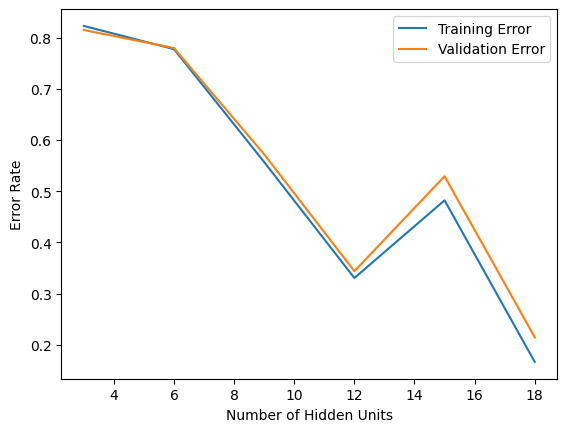

In [ ]:
train_mlp_with_diff_hidden_units('optdigits_train.txt', 'optdigits_valid.txt', 'optdigits_test.txt',[3, 6, 9, 12, 15, 18])


In [ ]:
def MLPTrain2(train_X, train_y, val_X, val_y, K, H, eta, epochs):
    X_train = train_X
    y_train = train_y.astype(int)

    X_val = val_X
    y_val = val_y.astype(int)

    # Initialize the weights
    D = X_train.shape[1]
    W = np.random.uniform(-0.01, 0.01, size=(D + 1, H))
    V = np.random.uniform(-0.01, 0.01, size=(H + 1, K))

    # Train the MLP
    train_errs = []
    val_errs = []
    for epoch in range(epochs):
        # Shuffle the training data
        perm = np.random.permutation(X_train.shape[0])
        X_train = X_train[perm]
        y_train = y_train[perm]
        
        # Iterate over each training sample
        for i in range(X_train.shape[0]):
            # Forward pass
            x = np.append(X_train[i], 1)  # add bias
            h = relu(np.dot(x, W))
            z = np.dot(np.append(h, 1), V)
            y = np.exp(z) / np.sum(np.exp(z))

            # Compute the error
            t = np.zeros(K)
            t[y_train[i]] = 1
            delta_k = y - t
            delta_h = np.dot(delta_k, V[:-1].T) * (h > 0)

            # Update the weights
            V -= eta * np.outer(np.append(h, 1), delta_k)
            W -= eta * np.outer(x, delta_h)

        # Compute the training and validation error rates
        train_preds = predict_mlp(X_train, W, V)
        train_err = 1 - np.mean(train_preds == y_train)
        train_errs.append(train_err)
        val_preds = predict_mlp(X_val, W, V)
        val_err = 1 - np.mean(val_preds == y_val)
        val_errs.append(val_err)
        
        print(f"Epoch {epoch+1}: Training error rate = {train_err:.4f}, Validation error rate = {val_err:.4f}")

    return W, V, np.array(train_errs), np.array(val_errs)

2 10
Epoch 1: Training error rate = 0.4896, Validation error rate = 0.4800
Epoch 2: Training error rate = 0.4527, Validation error rate = 0.4650
Epoch 3: Training error rate = 0.4458, Validation error rate = 0.4506
Epoch 4: Training error rate = 0.4826, Validation error rate = 0.4842
Epoch 5: Training error rate = 0.4437, Validation error rate = 0.4517
Epoch 6: Training error rate = 0.5008, Validation error rate = 0.5120
Epoch 7: Training error rate = 0.4832, Validation error rate = 0.4848
Epoch 8: Training error rate = 0.4378, Validation error rate = 0.4335
Epoch 9: Training error rate = 0.5003, Validation error rate = 0.5243
Epoch 10: Training error rate = 0.4859, Validation error rate = 0.4939
[5 4 8 ... 0 3 7]
(1874,)
[5 9 5 ... 0 3 7]
(1874,)


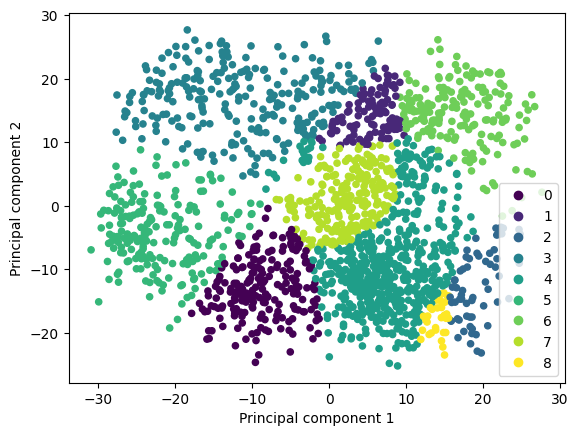

In [ ]:
# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Apply PCA to training data
X_train = pca.fit_transform(train_X)

# Apply PCA to test data using the same PCA object as for training
X_test = pca.transform(test_X)

# Apply PCA to validation data using the same PCA object as for training
X_val = pca.transform(val_X)

# Get the number of input features and output classes
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(test_y))

# Set the number of hidden units for the MLP
hidden_units = 12

# Train the MLP model and get the weight matrices and error history
W, V, train_errs, val_errs = MLPTrain2(X_train, train_y, X_val, val_y, 10, 100, 0.01, 10)

# Use the trained MLP model to predict the class labels of the test data
predicted_class = predict_mlp(X_test, W, V)

# Print the predicted class labels and their shape
print(predicted_class)
print(predicted_class.shape)

# Print the true class labels of the test data and their shape
print(test_y)
print(test_y.shape)

# Visualize the predicted class labels on the 2D PCA-transformed test data
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_class, s=20)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

2 10
[9 6 5 ... 0 3 7]
(1874,)
[5 9 5 ... 0 3 7]
(1874,)


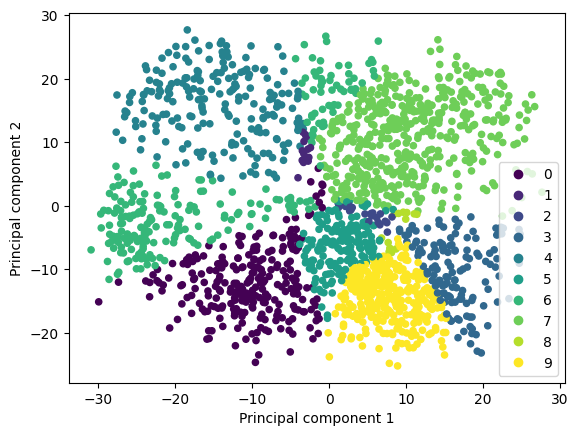

In [ ]:
pca = PCA(n_components=2)  # create a PCA object with 2 principal components

# use PCA to transform the training, testing, and validation data
X_train = pca.fit_transform(train_X)
X_test = pca.transform(test_X)
X_val = pca.transform(val_X)

n_inputs = X_train.shape[1]  # get the number of input features
n_outputs = len(np.unique(test_y))  # get the number of output classes
hidden_units = 12  # set the number of hidden units

print(n_inputs, n_outputs)

# create an MLP model with the given number of input features, hidden units, and output classes
model = MLP(n_inputs, hidden_units, n_outputs)

# train the model on the training data using the given hyperparameters
model.train(X_train, train_y, X_val, val_y, n_epochs=1000, eta=0.01)

# use the trained model to predict the class labels of the test data
predicted_class = model.predict(X_test)

print(predicted_class)
print(predicted_class.shape)

# print(train_y)

# W, V, train_errs, val_errs = MLPTrain2(X_train, train_y, X_val, val_y, 10, 100, 0.01, 10)
# predicted_class = predict_mlp(X_test, W, V)
# print(predicted_class)

print(test_y)
print(test_y.shape)

# plot a scatter plot of the test data with the predicted class labels as colors
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_class, s=20)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()